## Implementing neural style transfer model

This technique is outlined in the paper - <i>A Neural Algorithm of Artistic Style</i>. Based on the paper, I require a conv net which is trained on a large volume of images and has subsequently learned how to accurately classify images of different classes. I decided to use the VGG-19 model as described in the paper. I am using a [pretrained model](http://www.vlfeat.org/matconvnet/pretrained/#downloading-the-pre-trained-models) and am using a variation of a helper function found on [Github](https://github.com/JudasDie) to quickly read in the model. 

Note - "Loading parameters" in this case is essentially taking the generated image from earlier training and inputting that as the generated image for continued learning.

In [1]:
import scipy.io
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
np.random.seed(10)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Global variables for image height,width
n_h = 400
n_w = 300

In [3]:
# Initial images with valid shapes used for testing and first run through model

# Creating a randomly generated image
gen_img = np.random.rand(n_w,n_h,3)
# Loading content and style images
content_img = cv2.imread("../../data/neural_style/content_1.jpg") # christmas tree with presents
content_img = cv2.resize(content_img, (n_h,n_w), interpolation=cv2.INTER_AREA)
style_img = cv2.imread("../../data/neural_style/style_1.jpg") # bright painting
style_img = cv2.resize(style_img, (n_h,n_w), interpolation=cv2.INTER_AREA)

In [4]:
# Adjusting shapes
gen_img.shape = (1,n_w,n_h,3)
content_img.shape = (1,n_w,n_h,3)
style_img.shape = (1,n_w,n_h,3)

In [5]:
# Loads the VGG model based on pretrained parameters
def load_vgg_model(path,img_height,img_width,num_channels):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name): # Return weights and bias from VGG model for layer
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer): # Return relu function
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name): # Return Conv2d layer using trained weights
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name): # Returns Conv+Relu using pretrained weights
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer): # Returns AVGPool layer
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, img_height,img_width,num_channels)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [6]:
# Getting the output shapes for each layer of the model
tf.reset_default_graph()
with tf.Session() as sess:
    model = load_vgg_model("../../vgg/imagenet-vgg-verydeep-19.mat",n_w,n_h,3)
    sess.run(model["input"].assign(gen_img))
    cv11 = sess.run(model["conv1_1"])
    _,cv11w,cv11h,cv11c = cv11.shape
    print("conv1_1:",cv11.shape)
    cv21 = sess.run(model["conv2_1"])
    _,cv21w,cv21h,cv21c = cv21.shape
    print("conv2_1:",cv21.shape)
    cv31 = sess.run(model["conv3_1"])
    _,cv31w,cv31h,cv31c = cv31.shape
    print("conv3_1:",cv31.shape)
    cv41 = sess.run(model["conv4_1"])
    _,cv41w,cv41h,cv41c = cv41.shape
    print("conv4_1:",cv41.shape)
    cv51 = sess.run(model["conv5_1"])
    _,cv51w,cv51h,cv51c = cv51.shape
    print("conv5_1:",cv51.shape)
    cv42 = sess.run(model["conv4_2"])
    print("conv4_2:",cv42.shape)
    _,cv42w,cv42h,cv42c = cv42.shape

conv1_1: (1, 300, 400, 64)
conv2_1: (1, 150, 200, 128)
conv3_1: (1, 75, 100, 256)
conv4_1: (1, 38, 50, 512)
conv5_1: (1, 19, 25, 512)
conv4_2: (1, 38, 50, 512)


## Building content and style cost functions

### Style cost function

$$ J_{content}(C,G) = \frac{1}{2} || a^{[l](C)} - a^{[l](G)} ||^2$$

### Content cost function

$$ E_l(S,G) = \frac{1}{4 (n_h n_w)^2 n_c^2} || g^{[l](S)} - g^{[l](G)} ||^2 $$

$$ J_{style} = \sum_{l=0}^{L} w_l * E_l $$

### Total cost

$$  J_{total} = \alpha * J_{content} + \beta * J_{style} $$

$$ \frac{\alpha}{\beta} = 1*10^{-3} $$


Terms:
- C: content image
- S: style image
- G: generated image
- g: gram-matrix between two channels of a given activation
- a<sup>(l)(x)</sup>: activation for layer l of image x
- w<sub>l</sub>: weighting factors for each layers contribution to the style loss

As described in the paper mentioned above, I will be matching the content representation on layer "conv4_2". I will be matching the style representation on the layers "conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1" with each receiving an equal weighting.

#### Content cost function

In [21]:
# Content cost function
def content_cost(cont_act,gen_act):
    """
    cont_act: content image activation for layer "conv4_2", shape (1,38,50,512)
    gen_act: generated image activation for layer "conv4_2"
    """
    m,n_w,n_h,n_c = gen_act.get_shape().as_list()
    cont_act_u = tf.reshape(cont_act,(n_w*n_h,n_c)) # shape:(1,n_h*n_w,n_c)
    gen_act_u = tf.reshape(gen_act,(n_w*n_h,n_c))
    content_diff = tf.square(tf.subtract(cont_act_u,gen_act_u))
    content_cost = (1/(8*n_w)) * tf.reduce_sum(content_diff)
    return content_cost

In [8]:
# Testing content cost function
tf.reset_default_graph()
with tf.Session() as sess:
    model = load_vgg_model("../../vgg/imagenet-vgg-verydeep-19.mat",n_w,n_h,3)
    # Computation graph
    Content = tf.placeholder(tf.float32,(None,cv42w,cv42h,cv42c))
    Gen = tf.placeholder(tf.float32,(None,cv42w,cv42h,cv42c))
    J_content = content_cost(Content, Gen)
    # Getting input data
    sess.run(model["input"].assign(content_img)) # getting content image
    aContent = sess.run(model["conv4_2"])
    sess.run(model["input"].assign(gen_img))
    aGen = sess.run(model["conv4_2"])
    # Running graph
    cost_content = sess.run(J_content,feed_dict={Content:aContent,Gen:aGen})
    print("Content cost:",cost_content)

Content cost: 840572900.0


#### Style cost function

In [9]:
# Returns the gram matrix for a specific matrix of shape (n_c,n_h*n_w)
def gram_matrix(act):
    act_t = tf.transpose(act)
    return tf.matmul(act,act_t) # shape:(n_c,n_c)

In [10]:
# Computes style loss for a single layer, takes in two tf placeholders
def single_layer_style_cost(style_act,gen_act):
    m,n_w,n_h,n_c = gen_act.get_shape().as_list()
    style_act_t = tf.transpose(tf.reshape(style_act, (n_h*n_w, n_c))) # shape: (1,n_c,n_w*n_h)
    gen_act_t = tf.transpose(tf.reshape(gen_act, (n_h*n_w, n_c))) # shape: (1,n_c,n_w*n_h)
    gram_style = gram_matrix(style_act_t)
    gram_gen = gram_matrix(gen_act_t)
    style_diff = tf.square(tf.subtract(gram_style,gram_gen))
    style_cost = (1/(4 * (n_h*n_w)**2 * n_c**2)) * tf.reduce_sum(style_diff)
    return style_cost

In [11]:
# Testing style cost function
tf.reset_default_graph()
with tf.Session() as sess:
    model = load_vgg_model("../../vgg/imagenet-vgg-verydeep-19.mat",n_w,n_h,3)
    # Computation graph
    Style = tf.placeholder(tf.float32,(None,cv21w,cv21h,cv21c))
    Gen = tf.placeholder(tf.float32,(None,cv21w,cv21h,cv21c))
    J_style = single_layer_style_cost(Style, Gen)
    # Getting input data
    sess.run(model["input"].assign(style_img)) # getting content image
    aStyle = sess.run(model["conv2_1"])
    sess.run(model["input"].assign(gen_img))
    aGen = sess.run(model["conv2_1"])
    # Running graph
    cost_style = sess.run(J_style,feed_dict={Style:aStyle,Gen:aGen})
    print("Style cost:",cost_style)

Style cost: 80775640.0


In [12]:
# The style cost weights each layers activations equally
# Takes a list of layers as strings (i.e. "conv2_1") corresponding to layers used for style loss
def style_cost(layers,model,sess):
    total_cost = 0
    for layer in layers:
        activation = model[layer]
        style_act = sess.run(activation)
        gen_act = activation # evaluated when we assign the generated image to the model
        layer_cost = single_layer_style_cost(style_act,gen_act)
        total_cost += (0.2 * layer_cost)
        
    return total_cost

#### Total cost function

In [23]:
# Full cost function
def cost_function(style_cost,content_cost,alpha=1,beta=2):
    return alpha * content_cost + beta * style_cost

### Tensorflow Model

In [14]:
# shape: specifies the shape of the images (width,height)
def style_model(gen_img,cont_img,style_img,shape,model,lr=2,epochs=180,print_cost=True):
    tf.reset_default_graph() # reset graph
    costs = []
    g_images = []
    layers = ["conv1_1","conv2_1","conv3_1","conv4_1","conv5_1"] # layers to be used for style cost
    n_w,n_h = shape
    sess = tf.InteractiveSession() # Using an interactive session
    model = load_vgg_model("../../vgg/imagenet-vgg-verydeep-19.mat",n_w,n_h,3) # loading conv-net
    
    # Computation graph: 
    sess.run(model['input'].assign(cont_img)) # content cost
    act = model['conv4_2']
    cont_act = sess.run(act)
    gen_cont_act = act
    j_content = content_cost(cont_act,gen_cont_act)
    sess.run(model['input'].assign(style_img)) # style cost
    j_style = style_cost(layers,model,sess)
    cost = cost_function(j_style,j_content) # total cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    init = tf.global_variables_initializer() # initialize variables
    sess.run(init)
    sess.run(model['input'].assign(gen_img)) # Assigning the generated image to the model
    
    for epoch in range(epochs):
        _,a_cost = sess.run([optimizer,cost])
        costs.append(a_cost)
        generated_img = sess.run(model['input']) # Getting generated image
        g_images.append(generated_img)
        
        if print_cost and epoch % 1 == 0: # print cost every iter
            print("cost at epoch {}: {}".format(epoch+1,a_cost))
            
        if print_cost and epoch % 10 == 0: # print style,content cost
            j_con,j_sty = sess.run([j_content,j_style])
            print("Content cost at epoch {}: {}".format(epoch+1,j_con))
            print("Style cost at epoch {}: {}".format(epoch+1,j_sty))
            print("---------------------------")
            
    return g_images,costs

In [15]:
# Changing shapes for visualization
gen_img.shape = (n_w,n_h,3)
content_img.shape = (n_w,n_h,3)
style_img.shape = (n_w,n_h,3)

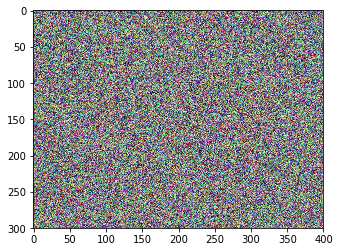

randomly generated image


In [16]:
# Visualizing input images
plt.imshow(gen_img)
plt.show()
print("randomly generated image")

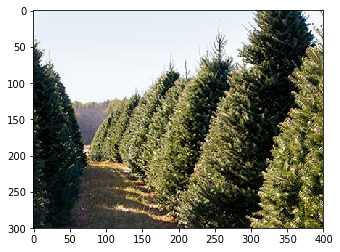

Content image


In [17]:
# Visualizing input images
plt.imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)) # cv2 reads in images in reverse channel order
plt.show()
print("Content image")

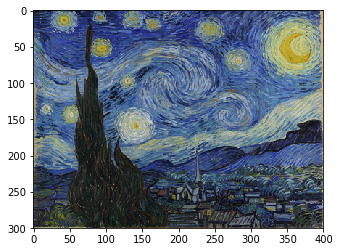

Style image


In [18]:
# Visualizing input images
plt.imshow(cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB))
plt.show()
print("Style image")

In [19]:
# Changing shapes for model input
gen_img.shape = (1,n_w,n_h,3)
content_img.shape = (1,n_w,n_h,3)
style_img.shape = (1,n_w,n_h,3)

### Generating Image

Note - matplotlib is displaying these images incorrectly, they should be darker. I didn't look to alter this output though, as I thought it was visually interesting in itself.

In [24]:
ag_images,acosts = style_model(gen_img,content_img,style_img,[n_w,n_h],model,lr=2,epochs=200,print_cost=True)

cost at epoch 1: 1124045568.0
Content cost at epoch 1: 413839968.0
Style cost at epoch 1: 350482240.0
---------------------------
cost at epoch 2: 1114804480.0
cost at epoch 3: 1091160448.0
cost at epoch 4: 1061006464.0
cost at epoch 5: 1024975104.0
cost at epoch 6: 984039552.0
cost at epoch 7: 939825536.0
cost at epoch 8: 894624384.0
cost at epoch 9: 850952704.0
cost at epoch 10: 810654336.0
cost at epoch 11: 774402880.0
Content cost at epoch 11: 323985600.0
Style cost at epoch 11: 208994400.0
---------------------------
cost at epoch 12: 741974400.0
cost at epoch 13: 713363456.0
cost at epoch 14: 688700672.0
cost at epoch 15: 667723072.0
cost at epoch 16: 649729600.0
cost at epoch 17: 633928448.0
cost at epoch 18: 619584640.0
cost at epoch 19: 606202432.0
cost at epoch 20: 593500928.0
cost at epoch 21: 581322752.0
Content cost at epoch 21: 285460960.0
Style cost at epoch 21: 142056128.0
---------------------------
cost at epoch 22: 569573248.0
cost at epoch 23: 558204800.0
cost at ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


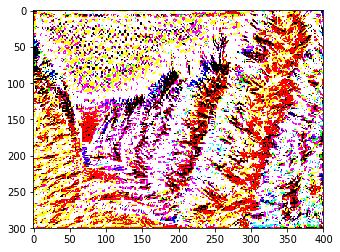

In [25]:
imgtest1 = ag_images[-1]
imgtest1.shape = (n_w,n_h,3)
plt.imshow(imgtest1)
plt.show()

In [26]:
imgtest1_input = imgtest1
imgtest1_input.shape = (1,n_w,n_h,3)

In [27]:
ag_images2,acosts2 = style_model(imgtest1_input,content_img,style_img,[n_w,n_h],model,lr=1.5,epochs=200,print_cost=True)

cost at epoch 1: 198042416.0
Content cost at epoch 1: 141180720.0
Style cost at epoch 1: 28301746.0
---------------------------
cost at epoch 2: 197784208.0
cost at epoch 3: 197039264.0
cost at epoch 4: 197637856.0
cost at epoch 5: 195550368.0
cost at epoch 6: 195712864.0
cost at epoch 7: 194480960.0
cost at epoch 8: 194243328.0
cost at epoch 9: 193743136.0
cost at epoch 10: 192899056.0
cost at epoch 11: 192624448.0
Content cost at epoch 11: 136564096.0
Style cost at epoch 11: 27769454.0
---------------------------
cost at epoch 12: 192103008.0
cost at epoch 13: 191460256.0
cost at epoch 14: 191114944.0
cost at epoch 15: 190614592.0
cost at epoch 16: 190054560.0
cost at epoch 17: 189669488.0
cost at epoch 18: 189188736.0
cost at epoch 19: 188683984.0
cost at epoch 20: 188293760.0
cost at epoch 21: 187823920.0
Content cost at epoch 21: 133859224.0
Style cost at epoch 21: 26746316.0
---------------------------
cost at epoch 22: 187351856.0
cost at epoch 23: 186948720.0
cost at epoch 24: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


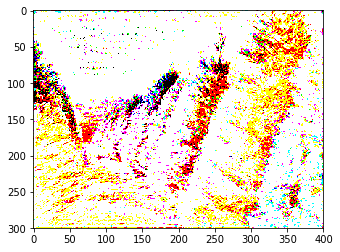

In [28]:
imgtest2 = ag_images2[-1]
imgtest2.shape = (n_w,n_h,3)
plt.imshow(imgtest2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


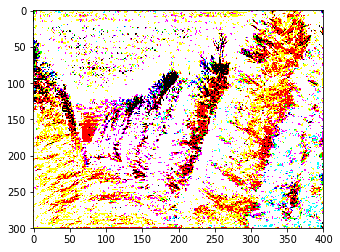

In [29]:
imgtest3 = ag_images2[100]
imgtest3.shape = (n_w,n_h,3)
plt.imshow(imgtest3)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


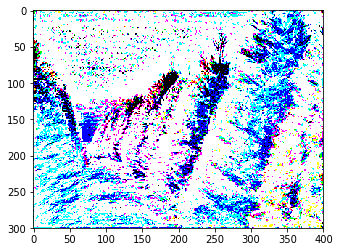

In [31]:
# Reserving colors to create more bluish tones
plt.imshow(cv2.cvtColor(imgtest3, cv2.COLOR_BGR2RGB))
plt.show()

### Saving all frames

In [32]:
all_imgs = ag_images + ag_images2
print(len(all_imgs))

400


In [36]:
for img in all_imgs:
    img.shape = (300,400,3)

In [37]:
img_array = np.array(all_imgs)
img_array.shape = (400,300,400,3)
print(img_array.shape)

(400, 300, 400, 3)


In [38]:
np.save("./img_array_tree.npy",img_array)

In [44]:
i = 0
for img in img_array:
    cv2.imwrite('./images/tree'+str(i)+".png",img)
    i += 1